### Data Loading

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape

(1000, 13551)

In [4]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Data preprocessing

In [6]:
def preprocess_X(X):
    X = X.toarray()
    return np.log1p(X * 1e4/ X.sum(axis=1)[:, np.newaxis])

X_train_norm = preprocess_X(X_train)

# # sanity check
# np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

In [7]:
X_train_norm.shape

(1000, 13551)

In [9]:
X_train

<1000x13551 sparse matrix of type '<class 'numpy.float32'>'
	with 1091156 stored elements in Compressed Sparse Row format>

### Dimensionality Reduction Analysis

#### High Variance Gene Selection Analysis

In [ ]:
def select_high_variance_features(X, top_k=2000, return_index=False):
    
    # Variance calculation for sparse matrix
    #col_mean = X.mean(axis=0)
    #col_mean_sq = X.power(2).mean(axis=0)
    #col_variance = np.array(col_mean_sq - np.power(col_mean, 2)).ravel()
    col_variance = np.var(X, axis=0)

    # Top-K variance feature indices
    top_idx = np.argsort(col_variance)[-top_k:]

    # Slice matrix to keep top features
    X_selected = X[:, top_idx]

    if return_index:
        return X_selected, top_idx
    return X_selected

In [25]:
X_train_selected= select_high_variance_features(X_train_norm, top_k=2000, return_index=False)

print("Shape:", X_train_selected.shape)

Shape: (1000, 2000)


#### PCA Component Analysis

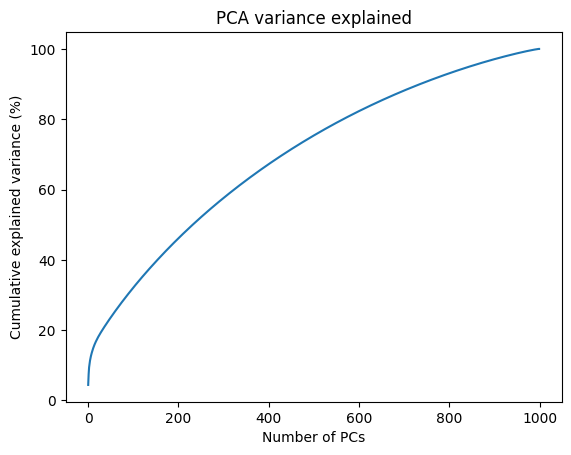

In [117]:
n_pcs = 1000
pca = PCA(n_components=n_pcs)
X_norm_pca = pca.fit_transform(X_train_norm)

plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA variance explained")
plt.show()

In [143]:
print("Cummulative Explained variance ratio (Last 10 PCs):", np.cumsum(pca.explained_variance_ratio_)[690:700])

Cummulative Explained variance ratio (Last 10 PCs): [0.8762322  0.8767771  0.8773215  0.8778655  0.87840873 0.8789507
 0.87949216 0.8800318  0.88057125 0.8811096 ]


### Model Building

In [36]:
# Logistic Regression Pipeline
logistic_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 700 components", PCA(n_components=100)),
        (
            "Logistic Regression",
                LogisticRegression(
                    solver='lbfgs',
                    penalty='l2',
                    C=1,
                    max_iter=1000,
                    # class_weight='balanced',
                    random_state=42,
                )
        ),
    ]
)

logistic_pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 700 components', PCA(n_components=100)),
                ('Logistic Regression',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [28]:
# Random Forest Regression Pipeline
rf_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 700 components", PCA(n_components=700)),
        (
            "Random Forest",
            RandomForestClassifier(
                n_estimators=300,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42,
                # n_jobs=-1  # Use all cores
            )
        ),
    ]
)

In [52]:
# XGBoost Classification Pipeline
xgb_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 700 components", PCA(n_components=700)),
        (
            "XGBoost",
            XGBClassifier(
                n_estimators=300,
                max_depth=15,
                learning_rate=0.1,  # Typical default; adjust as needed
                subsample=0.8,      # Optional: similar to RandomForest's randomness
                colsample_bytree=0.8, # Optional: similar to max_features
                random_state=42,
                use_label_encoder=False,  # Avoid warnings in latest XGBoost
                eval_metric='logloss',    # For classification
                scale_pos_weight=1         # Adjust if your classes are imbalanced
            )
        ),
    ]
)

### Model Evaluation

In [56]:
# define the model pipeline to use
pipe = xgb_pipe

In [53]:
# fit on train
X_train_norm = preprocess_X(X_train)
X_train_selected = select_high_variance_features(X_train_norm, top_k = 2000, return_index = False)
pipe.fit(X_train_selected, y_train)
y_tr_pred = pipe.predict(X_train_selected)

# predict on test
X_test_norm = preprocess_X(X_test)
X_test_selected = select_high_variance_features(X_test_norm, top_k = 2000, return_index = False)
y_te_pred = pipe.predict(X_test_selected)

Train balanced accuracy : 0.965
Test balanced accuracy : 0.277


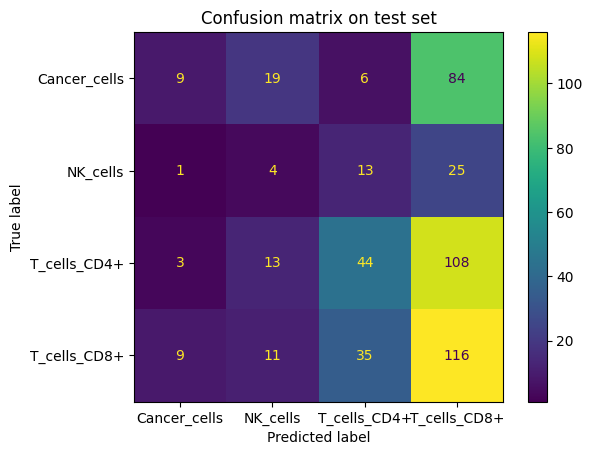

In [54]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");